## Sagnac Frequency - Backscatter Correction - Multi Day

## Imports

In [13]:
import os
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream
from scipy.signal import hilbert

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2023-11-23 16:00")
config['tend'] = UTCDateTime("2023-11-25 00:00")

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

## Configurations

In [5]:
def __load_backscatter_data(tbeg, tend, ring, path_to_data):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)-86400).date))

    df = DataFrame()
    for dat in date_range(t1, t2):
        print(dat)
        file = f"FJ{ring}_"+str(dat)[:10].replace("-","")+"_backscatter.pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    df.reset_index(inplace=True)

    return df

In [8]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

2023-11-23 00:00:00
2023-11-24 00:00:00


### Cut corrupt data periods

In [9]:
# times = [("2023-09-19 11:45", "2023-09-19 14:40"),
#          ("2023-09-19 15:50", "2023-09-19 16:00"),
#          ("2023-09-19 20:30", "2023-09-20 08:10"),
#          ("2023-09-20 09:50", "2023-09-20 12:00"),
#          ("2023-09-21 21:30", "2023-09-22 06:40"),
#          ("2023-09-22 11:30", "2023-09-22 12:30"),
#          ("2023-09-22 14:30", "2023-09-22 15:00"),
#         ]


# for t1, t2 in times:
#     bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
#     bs['w_s'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.w_s)

### Compute PSD

In [29]:
from functions.multitaper_psd import __multitaper_psd

dat1 = np.array((bs.fj_fs - bs.fj_fs.mean()).replace(np.nan, 0))
dat2 = np.array((bs.w_s - bs.w_s.mean()).replace(np.nan, 0))

# f1, psd1 = __multitaper_psd(dat1, 60, n_win=10)
# f2, psd2 = __multitaper_psd(dat2, 60, n_win=10)

f1, psd1 = __welch_psd(dat1, 60, twin_sec=86400)
f2, psd2 = __welch_psd(dat2, 60, twin_sec=86400)

# f1, psd1, pha1 = __get_fft(dat1, 60)
# f2, psd2, pha2 = __get_fft(dat2, 60)


### Load and convert tilt

In [14]:
def __to_tilt(data):
    from numpy import pi, sqrt, arccos, deg2rad, arcsin
    return (arcsin((data * 632.8e-9 * 3) / ( (2*pi/86400) * 36/3 * sqrt(3) )) - deg2rad(48.162941))

In [15]:
def __conversion_to_tilt(st, conf):

    st0 = st.copy()

    def convertTemp(trace):
        Tvolt = trace.data * conf.get('gainTemp')
        coeff = conf.get('calcTempCoefficients')
        return coeff[0] + coeff[1]*Tvolt + coeff[2]*Tvolt**2 + coeff[3]*Tvolt**3

    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity

    for tr in st0:
        if tr.stats.channel[-1] == 'T':
            tr.data = convertTemp(tr)
        elif tr.stats.channel[-1] == 'N':
            tr.data = convertTilt(tr, conf['convTN'], conf['gainTilt'])
        elif tr.stats.channel[-1] == 'E':
            tr.data = convertTilt(tr, conf['convTE'], conf['gainTilt'])
        else:
            print("no match")

    print(f"  -> converted data of {st[0].stats.station}")
    return st0

In [16]:
fs_tilt = __to_tilt(bs.w_s)

In [33]:
bromy = __read_sds(config['path_to_sds'], "BW.DROMY..LAT", config['tbeg']-600, config['tend']+600)
bromy += __read_sds(config['path_to_sds'], "BW.DROMY..LAN", config['tbeg']-600, config['tend']+600)

In [34]:
## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

bromy = __conversion_to_tilt(bromy, confTilt['BROMY'])

bromy2 = bromy.copy()
bromy2= bromy2.decimate(6, no_filter=False)
bromy2= bromy2.decimate(10, no_filter=False)

temp_gradient = np.gradient(bromy2[0].data, 60)[10:-10]

bromy.trim(config['tbeg'], config['tend'])
bromy2.trim(config['tbeg'], config['tend'])

  -> converted data of DROMY


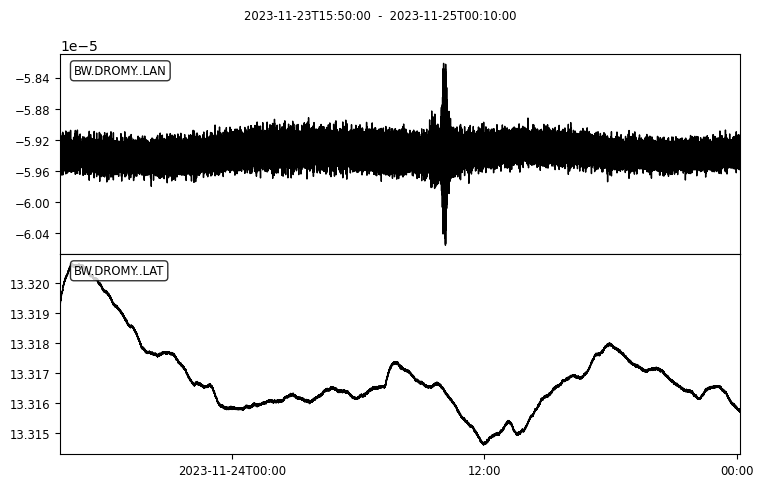

In [44]:
bromy.plot(equal_scale=False);

### Load WROMY data

In [254]:
from andbro__load_WROMY_stream import __load_wromy_stream

ws1 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS1", config['tbeg'], config['tend'])
ws5 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS5", config['tbeg'], config['tend'])
ws9 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS9", config['tbeg'], config['tend'])

Specified end: 2023-09-23T00:00:00.000000Z 
Trace end:     2023-09-22T23:59:59.000000Z
Specified end: 2023-09-23T00:00:00.000000Z 
Trace end:     2023-09-22T23:59:59.000000Z
Specified end: 2023-09-23T00:00:00.000000Z 
Trace end:     2023-09-22T23:59:59.000000Z


In [255]:
ws1 = ws1.decimate(6, no_filter=False)
ws1 = ws1.decimate(10, no_filter=False)

ws5 = ws5.decimate(6, no_filter=False)
ws5 = ws5.decimate(10, no_filter=False)

ws9 = ws9.decimate(6, no_filter=False)
ws9 = ws9.decimate(10, no_filter=False)

In [298]:
from functions.smoothing import __smooth

ws1_T = ws1.select(channel="*T")[0].data
ws1_T_smooth = __smooth(ws1_T, 60)
ws1_gradient = np.gradient(ws1_T_smooth, 5)

ws5_T = ws5.select(channel="*T")[0].data
ws5_T_smooth = __smooth(ws5_T, 60)
ws5_gradient = np.gradient(ws5_T_smooth, 5)

ws9_T = ws9.select(channel="*T")[0].data
ws9_T_smooth = __smooth(ws9_T, 60)
ws9_gradient = np.gradient(ws9_T_smooth, 5)

(-0.01, 0.01)

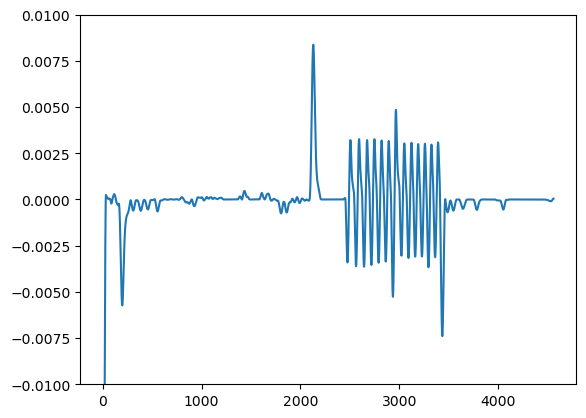

In [356]:
# plt.plot(ws1_gradient)
# plt.plot(ws5_gradient)
plt.plot(ws1_gradient-ws5_gradient)

plt.ylim(-0.01, 0.01)

### Plotting

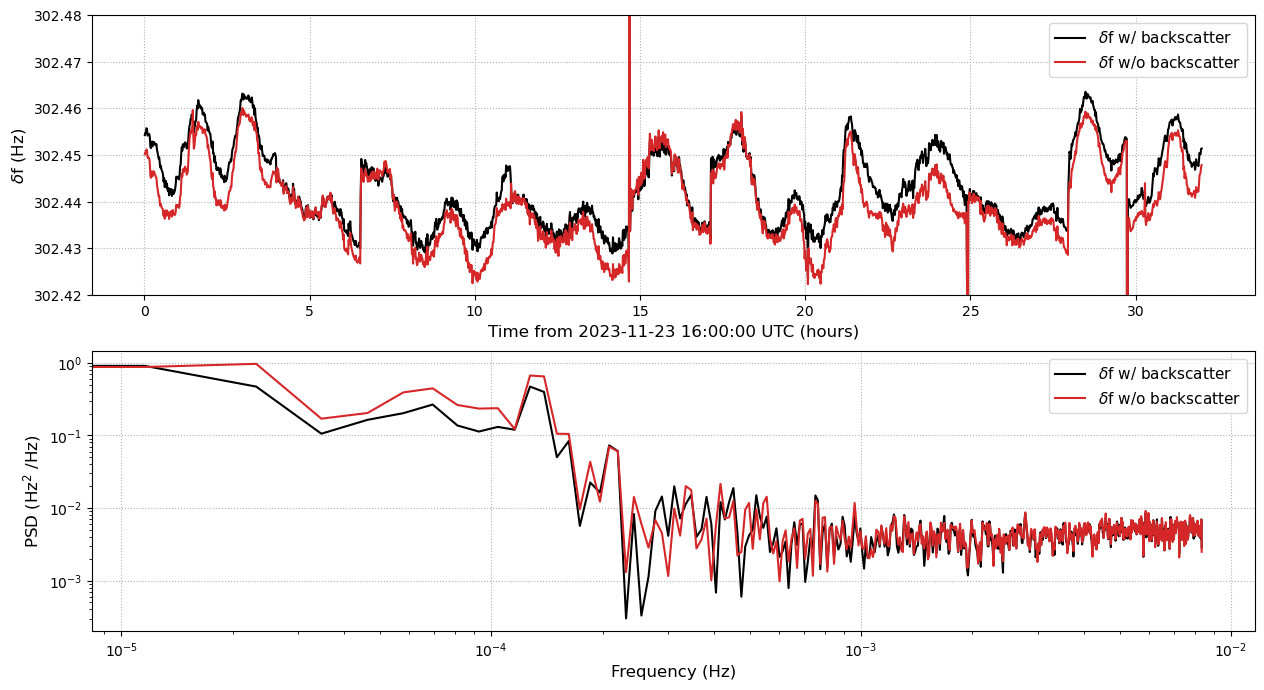

In [32]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].plot(bs.time_sec/3600, bs.fj_fs, color="black", label=f"$\delta$f w/ backscatter")
    ax[0].plot(bs.time_sec/3600, bs.w_s, color="tab:red", label=f"$\delta$f w/o backscatter")

    ax[0].ticklabel_format(useOffset=False)

    ax[1].loglog(f1, psd1, color="black", label=f"$\delta$f w/ backscatter")
    ax[1].loglog(f2, psd2, color="tab:red", label=f"$\delta$f w/o backscatter")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, fontsize=font-1)

    ax[0].set_ylim(302.42, 302.48)

    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC (hours)", fontsize=font)

    ax[1].set_ylabel("PSD (Hz$^2$ /Hz)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case2_PSD.png", format="png", dpi=200, bbox_inches='tight')


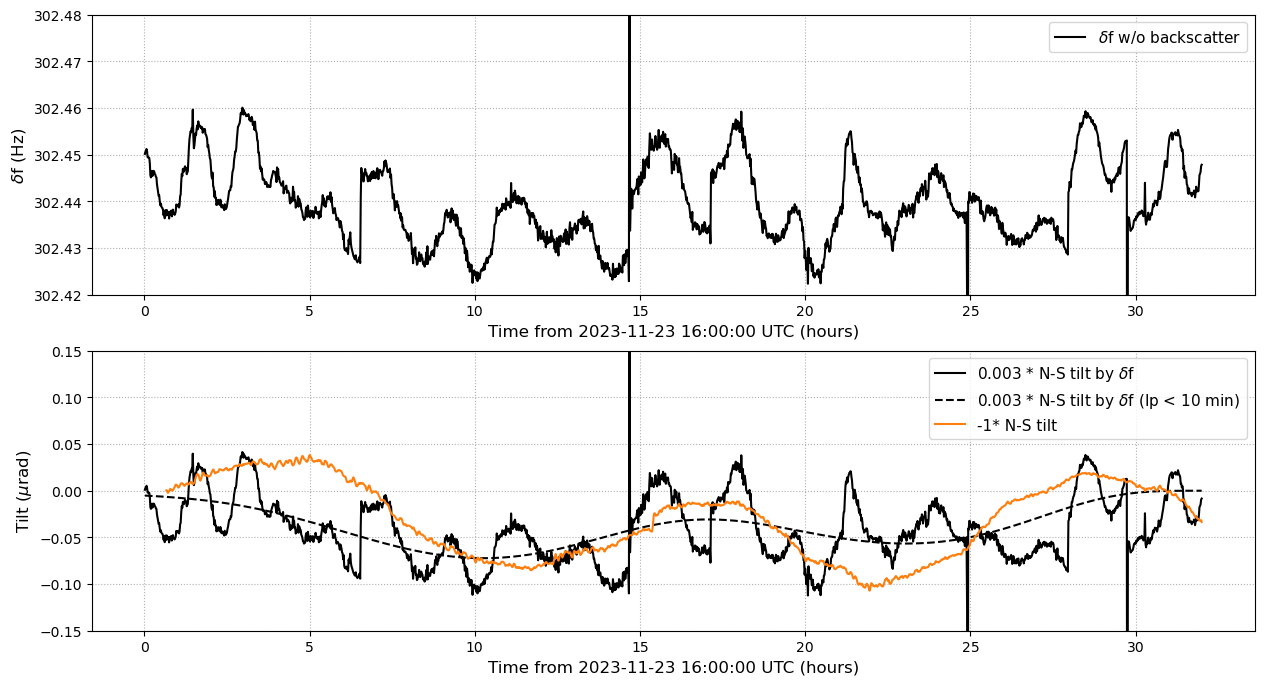

In [129]:
def __makeplot():

    dat = np.array((fs_tilt-np.mean(fs_tilt[:10])))

    tr = Trace()
    tr.data = dat
    tr.delta = 60
    tr.filter("lowpass", freq=1/600, corners=4, zerophase=True)

    fs_tilt_lp = tr.data


    Nrow, Ncol = 2, 1

    font = 12

    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    # ax[0].plot(bs.time_sec/3600, bs.fj_fs, color="black", label=f"$\delta$f w/ backscatter")
    ax[0].plot(bs.time_sec/3600, bs.w_s, color="black", label=f"$\delta$f w/o backscatter")
    ax[0].set_ylim(302.42, 302.48)
    ax[0].ticklabel_format(useOffset=False)


    ax[1].plot(bs.time_sec/3600, (fs_tilt-np.mean(fs_tilt[:10]))*tilt_scaling*0.003, color="k", label=f"0.003 * N-S tilt by $\delta$f")
    ax[1].plot(bs.time_sec/3600, fs_tilt_lp*tilt_scaling*0.003, ls="--", color="k", label=f"0.003 * N-S tilt by $\delta$f (lp < 10 min)")

    bromy_tilt = bromy2.select(channel="*N")[0].data
    ax[1].plot(bromy2.select(channel="*N")[0].times()[40:]/3600, -(bromy_tilt-np.mean(bromy_tilt[40:50]))[40:]*tilt_scaling, color="tab:orange", label=f"-1* N-S tilt")
    # ax[1].set_ylim(-59.5, -59.25)
    ax[1].set_ylim(-0.15, 0.15)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, fontsize=font-1)


    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC (hours)", fontsize=font)

    ax[1].set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax[1].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC (hours)", fontsize=font)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case2_Tilt.png", format="png", dpi=200, bbox_inches='tight')


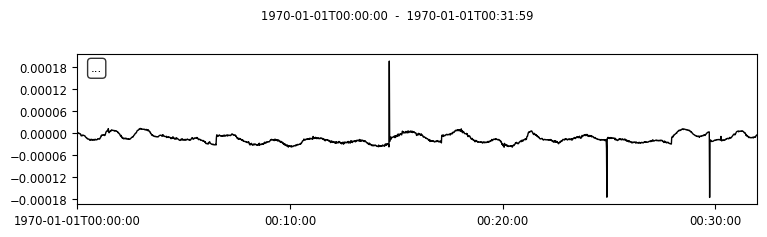

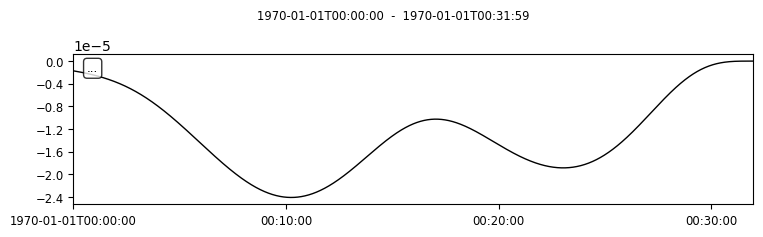

In [123]:
dat = np.array((fs_tilt-np.mean(fs_tilt[:10])))

tr = Trace()
tr.data = dat
tr.delta = 60

tr.plot();
tr.filter("lowpass", freq=1/600, corners=4, zerophase=True)
tr.plot();

fs_tilt_lp = tr.data

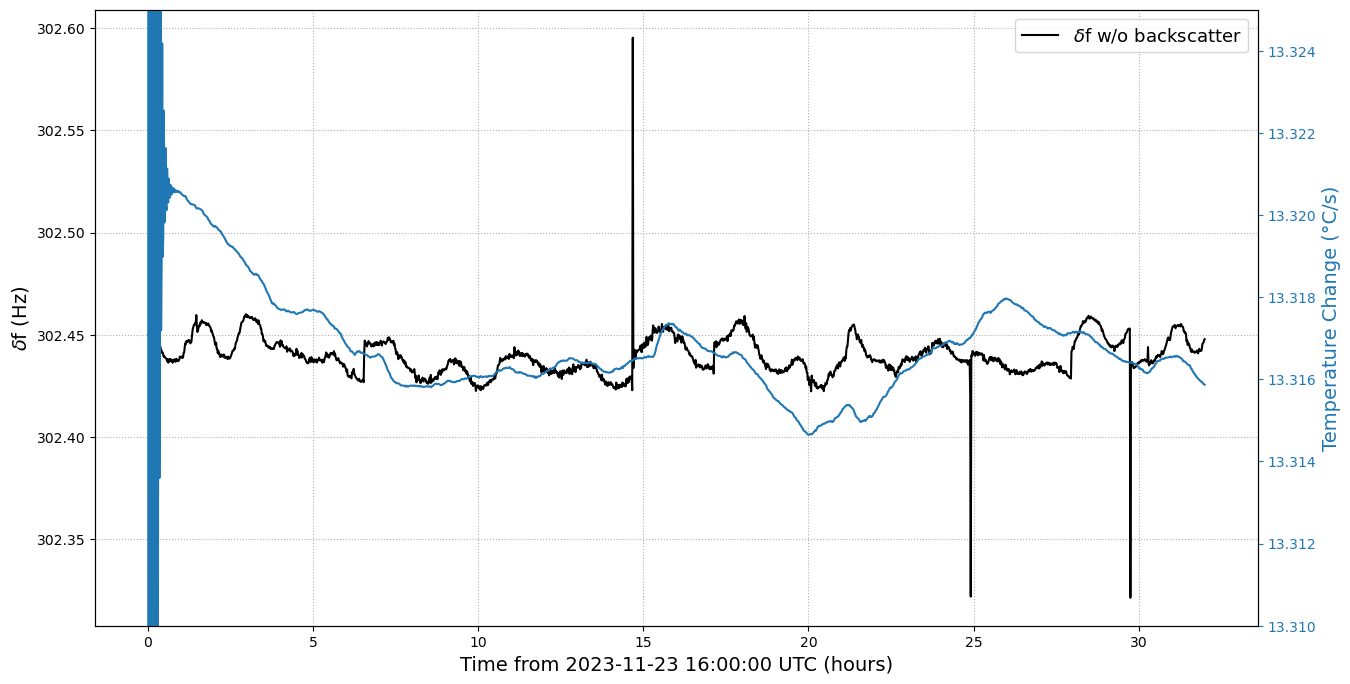

In [124]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 14

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax.plot(bs.time_sec/3600, bs.w_s, color="black", zorder=4, label=f"$\delta$f w/o backscatter")

    ax.ticklabel_format(useOffset=False)

    ax00 = ax.twinx()

    p2, = ax00.plot(bromy2[0].times()/3600, bromy2[0].data, color="tab:blue", label=f"", zorder=2)
    ax00.set_ylim(13.31, 13.325)

    # p2, = ax00.plot(bromy2[0].times()/3600, temp_gradient, color="tab:blue", label=f"", zorder=2)
    # ax00.set_ylim(-0.001, 0.001)

    # p2, = ax00.plot(ws1.select(channel="*T")[0].times()/3600, ws1_gradient, color="tab:blue", label=f"", zorder=2)
    # ax00.set_ylim(-0.01, 0.01)

    ax00.set_ylabel("Temperature Change (°C/s)", fontsize=font, color=p2.get_color())
    ax00.tick_params(axis='y', colors=p2.get_color())

    ax.grid(ls=":", zorder=1)
    ax.legend(loc=1, fontsize=font-1)

    # ax.set_ylim(302.97, 303.07)


    # ax.set_xlim(0, 108)
    # ax.set_xlim(30, 70)

    ax.set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax.set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC (hours)", fontsize=font)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_TemperatureChange_zoomin.png", format="png", dpi=200, bbox_inches='tight')


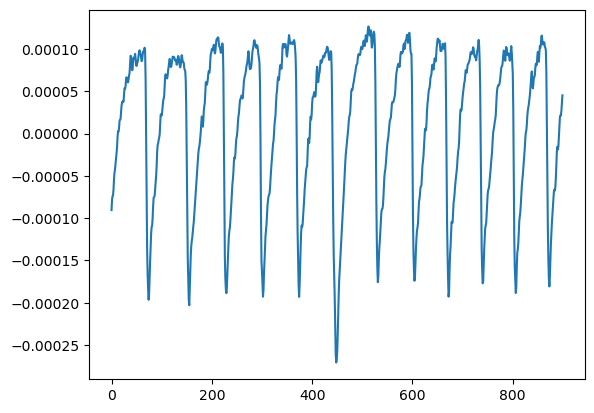

In [351]:
plt.plot(temp_gradient[2500:3400])
plt.plot(temp_gradient[2500:3400])

(-0.01, 0.01)

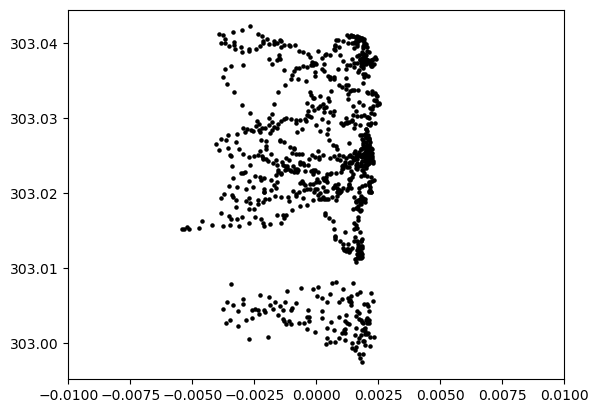

In [355]:
plt.scatter(temp_gradient[2500:3400]*20, bs.w_s[2500:3400], s=5, color="k")
plt.xlim(-0.01, 0.01)

In [57]:
from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd

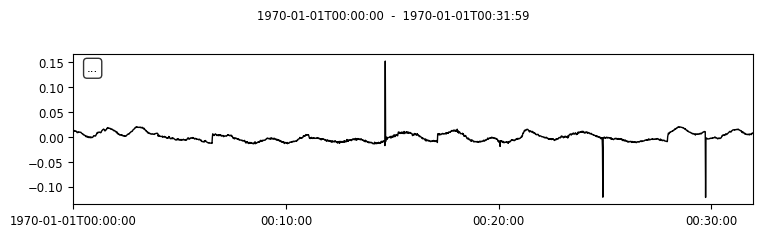

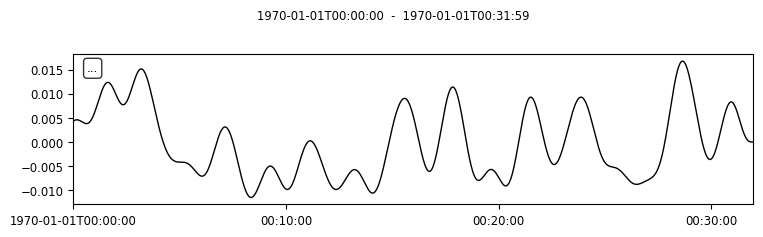

In [390]:
dat = np.array((bs.fj_fs - bs.fj_fs.mean()).replace(np.nan, 0))


tr = Trace()
tr.data = dat
tr.delta = 60

tr.plot();
tr.filter("lowpass", freq=0.01, corners=4, zerophase=True)
tr.plot();


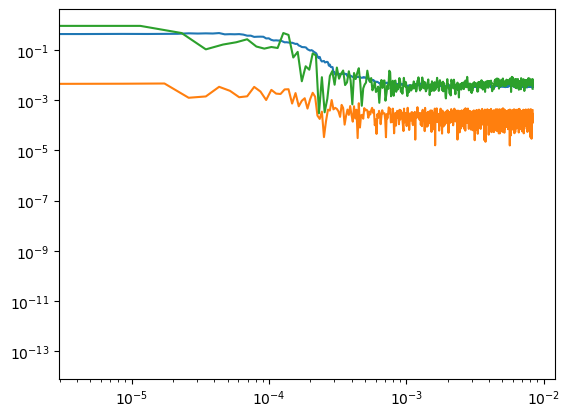

In [409]:
from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd

# data = np.array((bs.fj_fs - bs.fj_fs.mean()).replace(np.nan, 0))

# f1, psd1 = __multitaper_psd(tr.data, 60, n_win=10)
# f2, psd2, ph2 = __get_fft(tr.data, 60)
# f3, psd3 = __welch_psd(tr.data, 60, twin_sec=10)

f1, psd1 = __multitaper_psd(dat, 60, n_win=10)
f2, psd2, ph2 = __get_fft(dat, 60)
f3, psd3 = __welch_psd(dat, 60, twin_sec=86400)


plt.loglog(f1, psd1)
plt.loglog(f2, psd2)
plt.loglog(f3, psd3)
